In [65]:
import pyspark_csv as pycsv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import path
import random
from wordcloud import WordCloud, STOPWORDS, get_single_color_func

In [67]:
sc.addPyFile('pyspark_csv.py')
plaintext_rdd = sc.textFile('data/properati-merge2017-2016-2015-SOLOSIX.csv')
dataframe = pycsv.csvToDataFrame(sqlCtx, plaintext_rdd)
data = dataframe.rdd

# Solo capital federal y GBA

In [68]:
data_gba_and_capi = data.filter(lambda row: row.state_name.find('G.B.A') != -1 or row.state_name.find('Capital Federal') )

# Agrupo por tipo de propiedad (solo apartamento y casa)

In [69]:
group_apartment = data_gba_and_capi.filter(lambda row: row.property_type == "apartment")
group_house = data_gba_and_capi.filter(lambda row: row.property_type == "house")

In [70]:
data_gba_and_capi.first()

Row(id='07a95755ab902faea5061bd0c304800c74172ea1', created_on=datetime.datetime(2014, 9, 1, 0, 0), property_type='house', place_name='Belén de Escobar', place_with_parent_names='|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|Belén de Escobar|', state_name='Bs.As. G.B.A. Zona Norte', geonames_id=3436079, lat-lon='-34.3568951424,-58.7813120884', lat=-34.3568951424, lon=-58.7813120884, price=80000, currency='USD', price_aprox_local_currency=1381960.0, price_aprox_usd=80000.0, surface_total_in_m2=470, surface_covered_in_m2=None, price_usd_per_m2=170.212765957, price_per_m2=None, floor=None, rooms=None, expenses=None, description='CODIGO: 2363-BS1 ubicado en: Escobar , Barrio Stone -  Publicado por: DEZORZI PROPIEDADES. El precio es de USD 80000 null. Sobre calle Esmeralda, casi Topacios Casa  a refaccionar con dos departamentos de dos ambientes, cocina y baño, al frente, a terminar  Sobre asfalto Superficie de cada departamento: 30 m2 Superficie del lote  470m2 con variedad de árboles frutale

# Hacemos un split de cada palabra en la descripcion

In [71]:
all_properties_descrip = data_gba_and_capi.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")
group_house_descrip = group_house.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")
group_apartment_descrip = group_apartment.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")


In [72]:
all_properties_descripCountRDD = all_properties_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':').rstrip(';'),1))
group_house_descripCountRDD = group_house_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':').rstrip(';'),1))
group_apartment_descripCountRDD = group_apartment_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':').rstrip(';'),1))

In [73]:
all_properties_descripCountRDD.take(10)

[('codigo', 1),
 ('2363-bs1', 1),
 ('ubicado', 1),
 ('en', 1),
 ('escobar', 1),
 ('', 1),
 ('barrio', 1),
 ('stone', 1),
 ('-', 1),
 ('publicado', 1)]

In [74]:
all_properties_descripCountRDD = all_properties_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()
group_house_descripCountRDD = group_house_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()
group_apartment_descripCountRDD = group_apartment_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()

In [75]:
all_properties_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(10)

[('de', 999436),
 ('con', 666621),
 ('y', 583023),
 ('en', 429476),
 ('a', 254047),
 ('-', 235177),
 ('la', 227851),
 ('el', 165376),
 ('cocina', 143964),
 ('comedor', 137629)]

In [116]:
#Quitamos palabras y caracteres que son indeseables o no tienen importancia
preposiciones = ["a","ante","cabe","bajo","con","contra","de","desde","durante","en","entre","hacia","hasta",\
                "mediante","para","por","segun","sin","sobre","tras"]

otras_palabras = ["y","con","en","la","las","el","al","-","del","1","uno","una","2","dos","3","tres","se","los","un",\
                 "que","es","o","4",",",".","m2","mls","metros","null","través","son","x","en:","/","por:","no","null.","su","publicado",\
                  "venta","cuenta","ubicado","zona","san","precio","tiene","usd","esta","unidades","medidas","5","tipo",\
                 "como","más","av.","av","mts","+","#","este","id","superficie","u$s","10","cada","sus","6","*","24",\
                 "$","lo","está","ubicación","casa","apartamento","departamento","edificios","edificio",\
                  "departamentos","propiedades","codigo:","e","","m","muy","mas","todo","otro","amb","ambiente",\
                  "total","mat","todos","gran","ambientes","pa"]


In [117]:
all_properties_descripCountRDD = all_properties_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [118]:
group_house_descripCountRDD = group_house_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [119]:
group_apartment_descripCountRDD = group_apartment_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [120]:
all_properties_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(150)

[('cocina', 143964),
 ('comedor', 137629),
 ('baño', 112445),
 ('dormitorios', 100686),
 ('living', 97203),
 ('completo', 71140),
 ('dormitorio', 66539),
 ('planta', 65046),
 ('lavadero', 62731),
 ('parrilla', 57755),
 ('piso', 57094),
 ('suite', 55343),
 ('pisos', 54710),
 ('excelente', 50407),
 ('frente', 49684),
 ('amplio', 49461),
 ('cochera', 44257),
 ('placard', 43264),
 ('pileta', 40270),
 ('toilette', 39161),
 ('entrada', 35816),
 ('terraza', 35495),
 ('lote', 34434),
 ('vista', 34341),
 ('vestidor', 33746),
 ('principal', 33738),
 ('mesada', 32942),
 ('baja', 32921),
 ('propiedad', 32330),
 ('patio', 32118),
 ('alta', 31036),
 ('hall', 30385),
 ('diario', 29047),
 ('doble', 29011),
 ('servicio', 28969),
 ('salida', 28556),
 ('baã±o', 28303),
 ('acceso', 27538),
 ('madera', 26863),
 ('barrio', 26857),
 ('cubierta', 25640),
 ('muebles', 24845),
 ('balcón', 23452),
 ('escritorio', 23259),
 ('jardín', 22592),
 ('aire', 22396),
 ('cuadras', 21734),
 ('plantas', 21467),
 ('autos', 1

In [121]:
group_house_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(200)

[('comedor', 92081),
 ('cocina', 77711),
 ('baño', 72481),
 ('dormitorios', 71371),
 ('living', 60340),
 ('planta', 44916),
 ('suite', 43623),
 ('lavadero', 42590),
 ('completo', 40361),
 ('parrilla', 39429),
 ('dormitorio', 33676),
 ('lote', 31755),
 ('amplio', 31707),
 ('toilette', 28770),
 ('pileta', 28638),
 ('entrada', 27102),
 ('excelente', 26766),
 ('pisos', 26723),
 ('vestidor', 26613),
 ('principal', 25743),
 ('diario', 24895),
 ('servicio', 24714),
 ('alta', 23640),
 ('frente', 22965),
 ('hall', 22722),
 ('propiedad', 22355),
 ('doble', 21045),
 ('barrio', 20785),
 ('baã±o', 20698),
 ('piso', 20470),
 ('escritorio', 20215),
 ('placard', 20126),
 ('baja', 19974),
 ('autos', 18739),
 ('patio', 18716),
 ('jardín', 18700),
 ('madera', 18247),
 ('cochera', 18017),
 ('plantas', 17980),
 ('vista', 17613),
 ('salida', 17591),
 ('quincho', 16983),
 ('fondo', 15710),
 ('garage', 15454),
 ('galería', 15018),
 ('cubierta', 14956),
 ('acceso', 14874),
 ('dependencia', 14787),
 ('mesada', 

In [122]:
group_apartment_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(200)

[('cocina', 56466),
 ('comedor', 36707),
 ('piso', 32812),
 ('baño', 32067),
 ('living', 30852),
 ('dormitorio', 28745),
 ('completo', 26229),
 ('pisos', 24751),
 ('cochera', 24168),
 ('dormitorios', 23127),
 ('frente', 20929),
 ('placard', 20552),
 ('excelente', 20192),
 ('terraza', 17228),
 ('balcón', 17085),
 ('mesada', 16544),
 ('vista', 16112),
 ('parrilla', 16018),
 ('lavadero', 15793),
 ('amplio', 14792),
 ('cocheras', 14504),
 ('planta', 13779),
 ('balcon', 12656),
 ('muebles', 11503),
 ('estrenar', 11212),
 ('suite', 11181),
 ('pileta', 11124),
 ('acceso', 10990),
 ('integrada', 10620),
 ('salida', 9865),
 ('baja', 9721),
 ('sum', 9649),
 ('cuadras', 9602),
 ('aire', 9562),
 ('cubierta', 9554),
 ('centro', 9446),
 ('calidad', 9402),
 ('toilette', 9165),
 ('complejo', 9137),
 ('seguridad', 8703),
 ('piscina', 8430),
 ('aluminio', 8324),
 ('cuotas', 7601),
 ('madera', 7595),
 ('luminoso', 7421),
 ('doble', 7280),
 ('espacio', 7138),
 ('corredor', 7021),
 ('apto', 7021),
 ('unida

In [123]:
dict_house_descripts = {}
list_house_descripts_ordered = group_house_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_house_descripts_ordered:
    dict_house_descripts[a] = x
dict_house_descripts['baño'] += dict_house_descripts['baã±o']
dict_house_descripts.pop('baã±o')

20698

In [124]:
dict_apartment_descripts = {}
list_apartment_descripts_ordered = group_apartment_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_apartment_descripts_ordered:
    dict_apartment_descripts[a] = x
dict_apartment_descripts['baño'] += dict_apartment_descripts['baã±o']
dict_apartment_descripts.pop('baã±o')

6845

In [125]:
dict_all_descripts = {}
list_all_descripts_ordered = all_properties_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_all_descripts_ordered:
    dict_all_descripts[a] = x
dict_all_descripts['baño'] += dict_all_descripts['baã±o']
dict_all_descripts.pop('baã±o')

28303

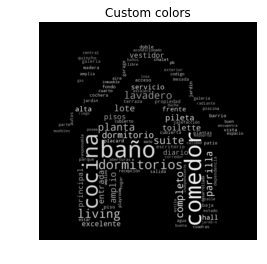

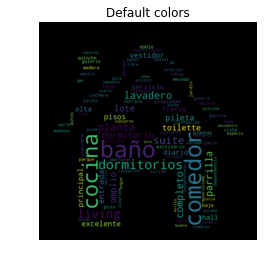

In [126]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"casa.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_house_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud per houses COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud per houses BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()


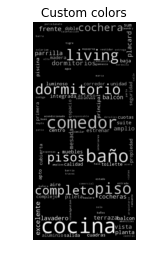

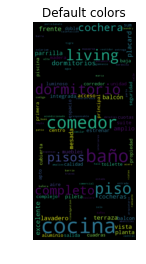

In [127]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"edificio2.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_apartment_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud per apartments COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud per apartments BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

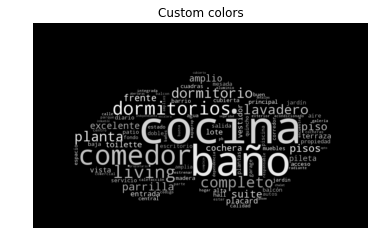

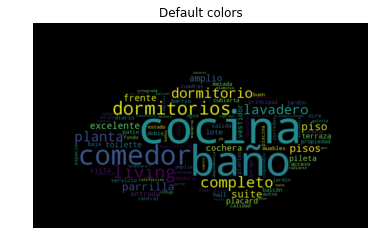

In [128]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"nube.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_all_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud all in COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud all in BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()